In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.metrics import f1

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
f_model = resnext50
PATH = 'data/iMaterialist/'
sz=224

In [9]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
val_idxs = get_cv_idxs(10000)
data = ImageClassifierData.from_csv(PATH, 'train_10kv2', f'{PATH}train_10kv2_labels.csv', tfms=tfms, val_idxs=val_idxs, suffix='.jpg', test_name='test')

In [11]:
learn = ConvLearner.pretrained(f_model, data, precompute=True, metrics=[f1])

100%|██████████| 621/621 [02:20<00:00,  4.43it/s]


## Step 1

First we begin retraining the last layer to map training images to our new labels. Because we do not need to send images through all but the last layer more than once, we turn on precompute to cache the vector embeddings before training the last fully connected logistic regression layer.

In [12]:
learn.lr_find(start_lr=1e-3, end_lr=1e3)

epoch      trn_loss   val_loss   f1         
    0      0.501836   0.807352   0.268139  



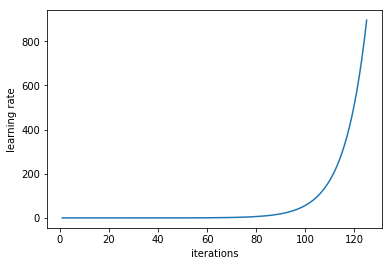

In [13]:
learn.sched.plot_lr()

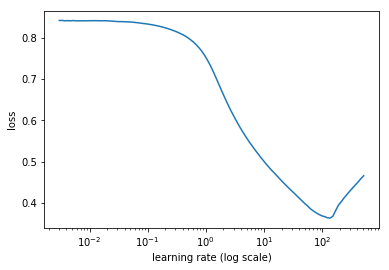

In [14]:
learn.sched.plot()

We started to see overfitting after 4 epochs. We will stop this initial training at 4 epochs

In [15]:
learn.fit(10, 4)

epoch      trn_loss   val_loss   f1         
    0      0.088675   0.071293   0.370338  
    1      0.072665   0.068837   0.382159  
    2      0.069675   0.068164   0.393849  
    3      0.067715   0.068129   0.393481  



[array([0.06813]), 0.39348099530950675]

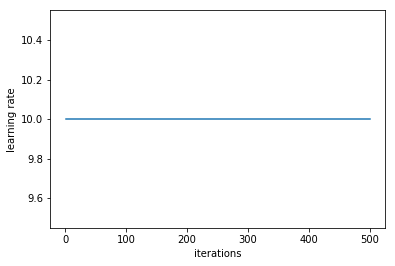

In [16]:
learn.sched.plot_lr()

## Step 2

Lets turn off precompute so we can use randomized crops / brightness levels / zooms for side-on image transformations. We will also add in some cycling of learning rates

In [17]:
learn.precompute=False

 97%|█████████▋| 121/125 [00:34<00:01,  3.48it/s, loss=0.278]

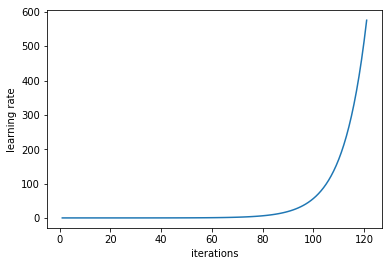

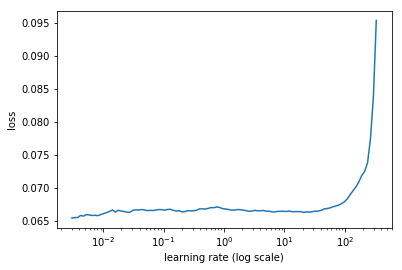

In [20]:
learn.lr_find(start_lr=1e-3, end_lr=1e3)
learn.sched.plot_lr()
plt.show()
learn.sched.plot()
plt.show()

In [21]:
learn.fit(1, 3, cycle_len=1)

 18%|█▊        | 22/125 [00:06<00:32,  3.18it/s, loss=0.0661]
epoch      trn_loss   val_loss   f1         
    0      0.066027   0.066818   0.409558  
    1      0.065376   0.066533   0.411182  
    2      0.064554   0.066351   0.415703  



[array([0.06635]), 0.4157032849486952]

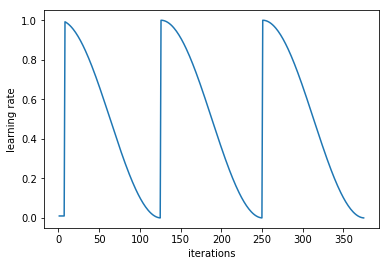

In [22]:
learn.sched.plot_lr()

## Step 3

Let's now tune the beginning, middle, and last layers with a couple more epochs and multiple the cycle len

I see significant overfitting after 2 cycles. May not need to use cycle_mult

In [23]:
learn.unfreeze()
lrs=np.array([0.01, 0.1, 1.0])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f1         
    0      0.066104   0.065701   0.42068   
    1      0.063372   0.064323   0.438442  
    2      0.060722   0.06415    0.440673  
    3      0.060295   0.064027   0.448085  
    4      0.057871   0.063775   0.458262  
    5      0.055179   0.063894   0.458285  
    6      0.053914   0.063918   0.460009  



[array([0.06392]), 0.4600092592297932]

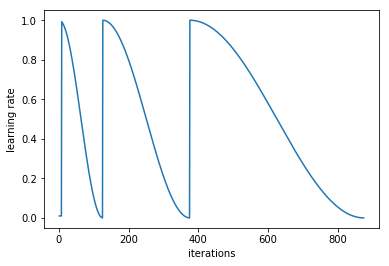

In [24]:
learn.sched.plot_lr()

## Step 4

Lets change the size so we avoid overfitting

epoch      trn_loss   val_loss   f1         
    0      0.055934   0.063318   0.465674  
    1      0.055835   0.063288   0.466135  
    2      0.05571    0.063424   0.466821  



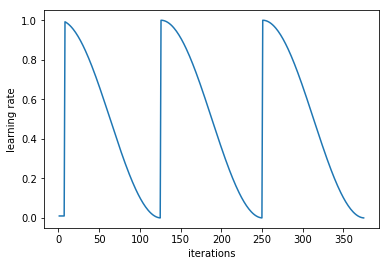

In [25]:
sz=299
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train_10kv2', f'{PATH}train_10kv2_labels.csv', tfms=tfms, val_idxs=val_idxs, suffix='.jpg', test_name='test')

learn.set_data(data)
learn.freeze()
learn.fit(lrs, 3, cycle_len=1)
learn.sched.plot_lr()

 94%|█████████▎| 117/125 [00:46<00:03,  2.54it/s, loss=0.228]

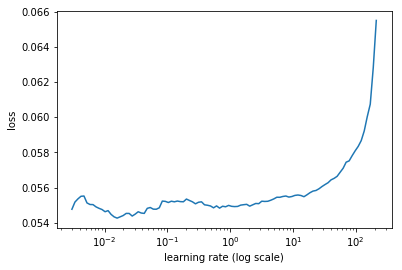

In [26]:
# Find next learning rate
learn.lr_find(start_lr=1e-3, end_lr=1e3)
learn.sched.plot()

In [76]:
learn.save('temp')

Now we want to unfreeze the earlier layers and retrain with larger images

  3%|▎         | 4/125 [00:06<03:06,  1.54s/it, loss=0.0573]
epoch      trn_loss   val_loss   f1         
    0      0.056471   0.063471   0.468686  
    1      0.056214   0.063456   0.469693  
    2      0.056259   0.063337   0.471314  



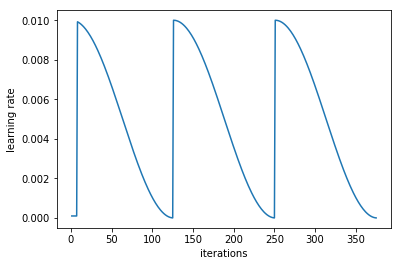

In [27]:
learn.unfreeze()
learn.fit([0.01/6./6., 0.01/6., .01], 3, cycle_len=1)
learn.sched.plot_lr()

In [28]:
learn.save('resnext50_train_10kv2_0.471314')

# Load Model and score on test data

In [16]:
f_model = resnet34
PATH = 'data/iMaterialist/'
sz=299

tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
val_idxs = get_cv_idxs(10000)
data = ImageClassifierData.from_csv(PATH, 'train_10kv2', f'{PATH}train_10kv2_labels.csv',
                                    tfms=tfms, val_idxs=val_idxs, suffix='.jpg', test_name='test')

learn = ConvLearner.pretrained(f_model, data, precompute=False, metrics=[f1])
learn.load('resnet34_train_10kv2_0.47985')

In [29]:
multi_preds, y = learn.TTA(is_test=True)
preds = np.mean(multi_preds, 0)

This generates a label for each multilabel where score > 0.5

In [30]:
cs = np.array(learn.data.classes)
label_preds = list(map(lambda x: ' '.join(cs[x]), (preds > 0.5)))

In [31]:
test_ids = list(map(lambda x: int(x[5:-4]), data.test_ds.fnames))

In [32]:
pred_df = (
    pd.DataFrame(list(zip(test_ids, label_preds)),
                 columns=['image_id', 'label_id'])
    .sort_values('image_id')
    .reset_index(drop=True)
)

In [33]:
pred_df.head()

,image_id,label_id
0,1,105 214 66
1,2,17 20 66
2,3,154 171 186 66
3,4,153 164 53
4,5,153 171 184 62 66


# Get the right labels for first 10,000 images where urls match validation

In [34]:
ls /home/paperspace/data/iMaterialist/

labels.csv                                   tmp/
labels.gz                                    train_10k/
models/                                      train_10kv2/
sample_submission.csv                        train_10kv2_labels.csv
sample_submission.csv.zip                    train.json
submission_resnet34_train_10kv2_0.47985.csv  train.json.zip
test/                                        valid/
test.json                                    validation.json
test.json.zip                                validation.json.zip


In [35]:
import json

In [36]:
with open('data/iMaterialist/test.json') as f:
    test_urls = pd.DataFrame(json.load(f)['images'])
    
with open('data/iMaterialist/validation.json') as f:
    j = json.load(f)
    valid_urls = pd.DataFrame(j['images'])
    valid_labels = pd.DataFrame(j['annotations'])
    valid_labels['labelId'] = valid_labels['labelId'].apply(lambda x: ' '.join(x))
    valid = valid_urls.merge(valid_labels, how='inner', on='imageId')[['url', 'labelId']]
test_labels = test_urls.merge(valid, how='inner', on='url').drop('url', axis=1)

In [37]:
test_labels.head()

,imageId,labelId
0,1,62 17 66 214 105 137 85
1,2,95 17 66 214 164 137 20 204 184
2,3,122 19 66 186 180 44 154 20
3,4,190 222 66 153 164 226 53 184
4,5,62 66 153 171 111 137 70 204 184


In [38]:
test_labels.tail()

,imageId,labelId
9892,9893,189 66 111 180 176 20
9893,9894,33 117 106 53 184
9894,9895,190 113 153 164 222 53 184
9895,9896,18 66 222 131 205 105 44
9896,9897,95 17 66 25 226 222 153 164 59 181


Add known labels from validation set to top 9897 image ids

In [39]:
pred_df.loc[:9896, 'label_id'] = test_labels['labelId'].values
display(pred_df.head())
display(pred_df.loc[9890:9900, :])

,image_id,label_id
0,1,62 17 66 214 105 137 85
1,2,95 17 66 214 164 137 20 204 184
2,3,122 19 66 186 180 44 154 20
3,4,190 222 66 153 164 226 53 184
4,5,62 66 153 171 111 137 70 204 184


,image_id,label_id
9890,9891,193 222 66 164 53 175 87
9891,9892,62 17 66 171 153 20 204 184
9892,9893,189 66 111 180 176 20
9893,9894,33 117 106 53 184
9894,9895,190 113 153 164 222 53 184
9895,9896,18 66 222 131 205 105 44
9896,9897,95 17 66 25 226 222 153 164 59 181
9897,9898,151 19 59 66
9898,9899,17 171 214 66
9899,9900,106


In [ ]:
pred_df.to_csv('data/iMaterialist/submission_resnext50_train_10kv2_0.471314.csv', index=False)

In [ ]:
!head -10 /home/paperspace/data/iMaterialist/submission_resnet34_train_10kv2_0.47985.csv

In [ ]:
!head -10 /home/paperspace/data/iMaterialist/sample_submission.csv